In [1]:
import os # accessing directory structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt # plotting
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
import plotly.express as px

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, experimental, MaxPool2D, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.data import Dataset
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from tensorflow import test
import random

# Set Seed
np.random.seed(11)
set_seed(11)
random.seed(11)

Data description:

Age: ranges from 0-116
Ethnicity: 0 - White, 1 - Black, 2 - Asian, 3 - Indian, 4 - Other
Gender: 0 is male, 1 is female

In [2]:
#read data and show
age_gender_data = pd.read_csv("/Users/srividyaraghavan/Downloads/age_gender.csv")
age_gender_data.info()
age_gender_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


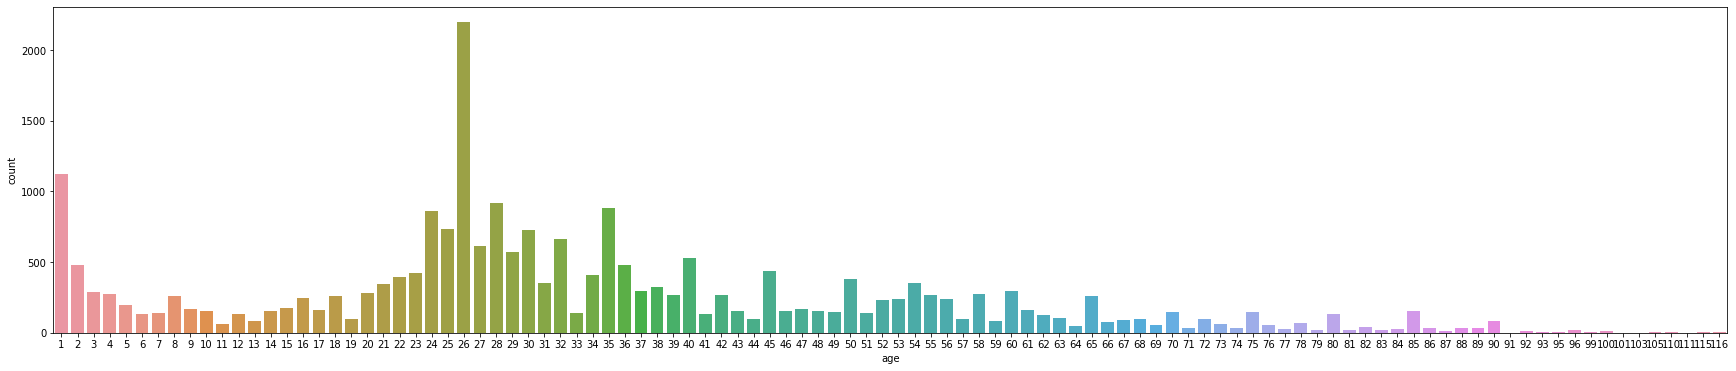

In [3]:
#plot age distrib with seaborn
fig_dims = (30, 6)
fig= plt.subplots(figsize=fig_dims)
sns.countplot(x = "age",data=age_gender_data)

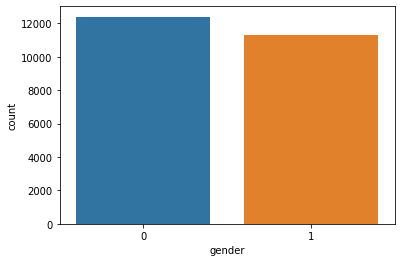

In [4]:
#plot gender distribution
sns.countplot(x = "gender", data=age_gender_data)

In [5]:
#Data preprocessing

#filter out ages younger than 18
age_gender_data = age_gender_data[age_gender_data["age"] >= 18]
age_gender_data.reset_index(drop=True, inplace=True)
age_gender_data

,age,ethnicity,gender,img_name,pixels
0,100,0,0,20170112213500903.jpg.chip.jpg,203 185 139 163 176 184 186 175 175 156 159 13...
1,100,0,0,20170112215240346.jpg.chip.jpg,125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2,100,0,1,20170110183726390.jpg.chip.jpg,235 164 113 144 121 201 243 237 234 221 233 23...
3,100,0,1,20170112213001988.jpg.chip.jpg,82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4,100,0,1,20170112213303693.jpg.chip.jpg,70 72 94 149 154 166 175 169 172 161 176 187 2...
...,...,...,...,...,...
19467,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [6]:
#normalize images by formating to 2304 px and 48x48
num_pixels = len(age_gender_data['pixels'][0].split(' '))
dimension = int(np.sqrt(num_pixels))
img_width = dimension
img_height = dimension

print("Pixels: {}".format(num_pixels))
print("Width: {0}, Height: {1}".format(img_width, img_height))

Pixels: 2304
Width: 48, Height: 48


In [7]:
from PIL import Image
import numpy
#Split the dataset

#X and Y split

#input the image
X_img = age_gender_data.iloc[:,4].copy()
#output the age, ethnicity, gender
y_age = age_gender_data.iloc[:,0].copy()
y_ethnicity = age_gender_data.iloc[:,1].copy()
y_gender = age_gender_data.iloc[:,2].copy()

#Split into train, test (te), and validation sets
X_train, X_te, y_train, y_te = train_test_split(X_img,y_gender,test_size=0.3,random_state=11)
X_val, X_test, y_val, y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

def str_to_npArr(x):
    #reset indicies in df
    x = x.reset_index(drop=True)
    #convert to numpy array
    x = x.apply(lambda x: np.array(x.split(), dtype="float32"))
    return np.array([x[i].reshape(img_width, img_height, 1) for i in range(x.shape[0])])

# Converting the string of pixels into image array for each of train, val and test set and normalization
X_train = str_to_npArr(X_train)
X_test = str_to_npArr(X_test)
X_val = str_to_npArr(X_val)

print("Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>")
print("Current: shape = {}, type = {}".format(X_train.shape, type(X_train)))
#can see that target and current are not the same

Target: shape = (16593, 48, 48, 1), type = <class 'numpy.ndarray'>
Current: shape = (13630, 48, 48, 1), type = <class 'numpy.ndarray'>


In [10]:
target_columns = ['gender', 'ethnicity', 'age']

#drop, not important for this part
age_gender_data_preprocess = age_gender_data.drop('img_name', axis=1)
y = age_gender_data_preprocess[target_columns]
X = age_gender_data_preprocess.drop(target_columns, axis=1)

print(X)
print("--------------------------------------------------------")
print(y)

                                                  pixels
0      203 185 139 163 176 184 186 175 175 156 159 13...
1      125 126 115 78 66 66 77 85 95 102 117 138 138 ...
2      235 164 113 144 121 201 243 237 234 221 233 23...
3      82 82 82 82 82 82 84 86 90 85 104 105 102 154 ...
4      70 72 94 149 154 166 175 169 172 161 176 187 2...
...                                                  ...
19467  127 100 94 81 77 77 74 99 102 98 128 145 160 1...
19468  23 28 32 35 42 47 68 85 98 103 113 117 130 129...
19469  59 50 37 40 34 19 30 101 156 170 177 184 187 1...
19470  45 108 120 156 206 197 140 180 191 199 204 207...
19471  156 161 160 165 170 173 166 177 183 191 187 18...

[19472 rows x 1 columns]
--------------------------------------------------------
       gender  ethnicity  age
0           0          0  100
1           0          0  100
2           1          0  100
3           1          0  100
4           1          0  100
...       ...        ...  ...
19467       1          

In [11]:
#convert to numpy array
X = X['pixels'].apply(lambda x: np.array(x.split(), dtype="float32"))
#normalize by converting to grayscale
X = np.array(X)/255.0
#normalize sizes to 48x48
X = np.array([ X[i].reshape(48,48,1) for i in range(X.shape[0]) ])


#X target and currents match
print("Target: X Shape: {}".format(X.shape))
print("Current: X Shape: {}".format(X.shape))

Target: X Shape: (19472, 48, 48, 1)
Current: X Shape: (19472, 48, 48, 1)


In [12]:
#reassign vars to updated df
y_gender = np.array(y['gender'])
y_ethnicity = np.array(y['ethnicity'])
y_age = np.array(y['age'])


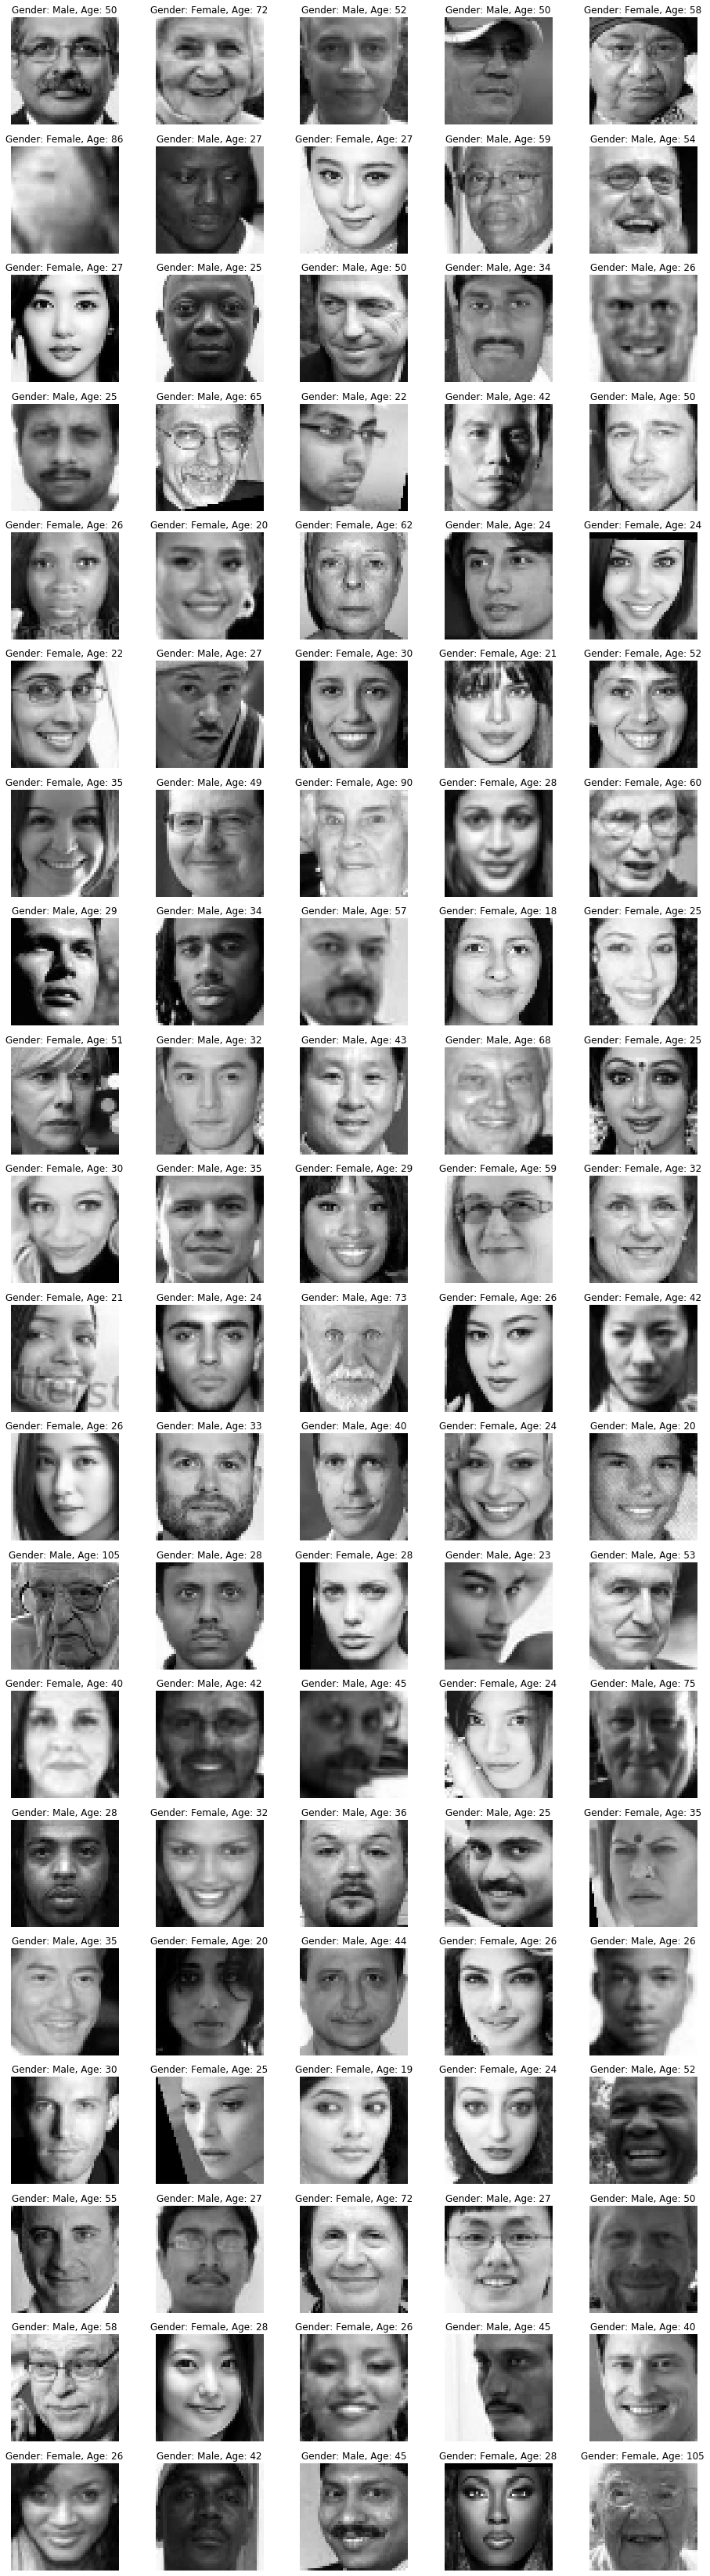

In [13]:
# see data samples

rows = 20
cols = 5

#select 100 random samples to display
samp = random.sample(range(X.shape[0]),rows*cols)
x_samp = X[samp,:,:,:]
y_samp_gender = y_gender[samp]
y_samp_age = y_age[samp]
    
fig,ax = plt.subplots(rows,cols,figsize=(16,60))
#reset to 0
r = 0
c = 0   

for i in range(rows*cols):
    #reshape to 48x48
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    #grayscale
    ax[r,c].imshow(aa,cmap="gray")
    #show gender and age
    ax[r,c].set_title(f"Gender: {'Female' if y_samp_gender[i]==1 else 'Male'}, Age: {y_samp_age[i]}")
    c+=1
    if c == cols:
        c=0
        r+=1
        
plt.show()

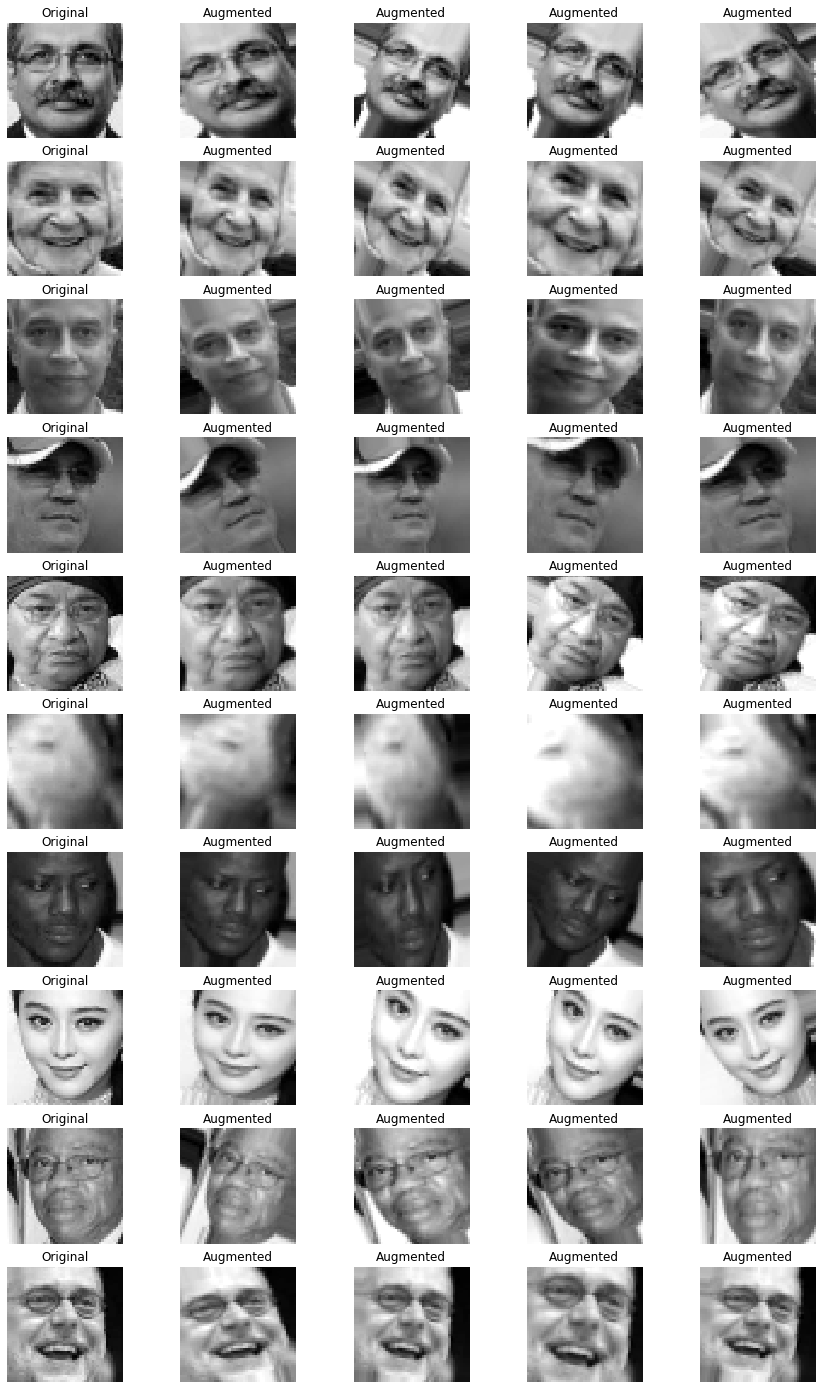

In [14]:
#transform data: data augmentation

#rotate, shift brightness and width, rescale
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )
val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)
set_seed(11)
random.seed(11)
np.random.seed(11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

fig,ax = plt.subplots(10,5,figsize=(15,25))
#show augmented images
for n in range(10):    
    r = random.sample(range(X.shape[0]),1)[0]
    ax[n,0].imshow(X[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

In [19]:
#Create the ML model
batch_size = 32
img_width, img_height, img_num_channels = 48, 48, 1
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 20
optimizer = Adam()
verbosity = 2
num_folds = 5
#using softmax because it's multiclass classification
activation='softmax'

#shape of data (48x48, 1)
input_shape = (img_width, img_height, img_num_channels)
input_shape

(48, 48, 1)

In [16]:
#set seed (starting point)

random.seed(11)
set_seed(11)
np.random.seed(11)

#k fold cross validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [ ]:
#score for loss and accuracy per fold

acc_per_fold = []
loss_per_fold = []

#K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y_gender):
    
  #Set Seed
  random.seed(11)
  set_seed(11)
  np.random.seed(11)
    
#model architecture

model = Sequential()
  
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

#final output layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='softmax'))
    
#compile
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])
  
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

#make sure the loss is going down, not overfitting
early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min")
    
#Set Seed
random.seed(11)
set_seed(11)
np.random.seed(11)
    
  #fit data
history = model.fit(train_data_gen.flow(X[train], y_gender[train], seed=11),
            callbacks=early_stop,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=train_data_gen.flow(X[test], y_gender[test],
                                   seed=11))
  
  #make a plot to evaluate model
fig = px.line(
history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'loss'}, 
title='Training History')
fig.show()
    
scores = model.evaluate(train_data_gen.flow(X[test], y_gender[test],
                                   seed=11), verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])
  
  # Increase fold number
fold_no = fold_no + 1
    

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
487/487 - 393s - loss: 0.5749 - accuracy: 0.7622 - val_loss: 0.7135 - val_accuracy: 0.6335
Epoch 2/20
487/487 - 361s - loss: 0.3315 - accuracy: 0.8605 - val_loss: 0.2970 - val_accuracy: 0.8811
Epoch 3/20
487/487 - 309s - loss: 0.2928 - accuracy: 0.8817 - val_loss: 0.3271 - val_accuracy: 0.8742
Epoch 4/20
487/487 - 340s - loss: 0.2729 - accuracy: 0.8874 - val_loss: 0.3038 - val_accuracy: 0.8752
Epoch 5/20
487/487 - 354s - loss: 0.2555 - accuracy: 0.8990 - val_loss: 0.2862 - val_accuracy: 0.8847
Epoch 6/20
487/487 - 370s - loss: 0.2387 - accuracy: 0.9069 - val_loss: 0.2400 - val_accuracy: 0.9027
Epoch 7/20
487/487 - 372s - loss: 0.2304 - accuracy: 0.9117 - val_loss: 0.2686 - val_accuracy: 0.8947
Epoch 8/20
487/487 - 373s - loss: 0.2217 - accuracy: 0.9142 - val_loss: 0.2270 - val_accuracy: 0.9127
Epoch 9/20
487/487 - 368s - loss: 0.2125 - accuracy: 0.9202 - val_loss: 0.2756 - val_ac

In [ ]:
#use validation data before testing
Final_train = np.append(X_train, X_val, axis=0)
Final_val = np.append(y_train, y_val, axis=0)
final_training_data = train_data_gen.flow(Final_train, Final_val,
                                   seed=11)

random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(train_data_gen.flow(X, y_gender, seed=11),batch_size=32,epochs=20, validation_data=val_data)

In [ ]:
#show training vs validation loss -- look for overfitting

fig = px.line(
final_model_history.history, y=['loss', 'val_loss'],
labels={'index': 'epoch', 'value': 'val_loss'}, 
title='Training History')
fig.show()

fig = px.line(
final_model_history.history, y=['accuracy', 'val_accuracy'],
labels={'index': 'epoch', 'value': 'accuracy'}, 
title='Training History')
fig.show()

In [ ]:
#evaluate how accurately the model performs on testing dataset
model.evaluate(test_data)
y_pred = model.predict_classes(test_data)
print(classification_report(y_test, y_pred))

In [ ]:
#show confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt='d');

In [ ]:
#error analysis - find and show errors

error_index = (y_test != y_pred)#where the prediction didn't match label
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = y_pred[error_index]

In [ ]:
#show images that were wrong, with true and prediction

rows=int(np.floor(sum(error_index)/3)) #rows in subplots
cols=3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,50))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp.iloc[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()